In [2]:
import numpy  as np
import pandas as pd
import os

import hashlib
import datetime
import warnings
import pickle
import gc

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

In [7]:
from sklearn.datasets import make_classification
from sklearn.metrics import brier_score_loss

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import normalize, StandardScaler
from sklearn.metrics         import classification_report, roc_curve, auc,accuracy_score, confusion_matrix, f1_score, fbeta_score
from sklearn.calibration     import CalibratedClassifierCV, calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import lightgbm as lgb      

In [4]:
from IPython.display import display

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [13, 7]

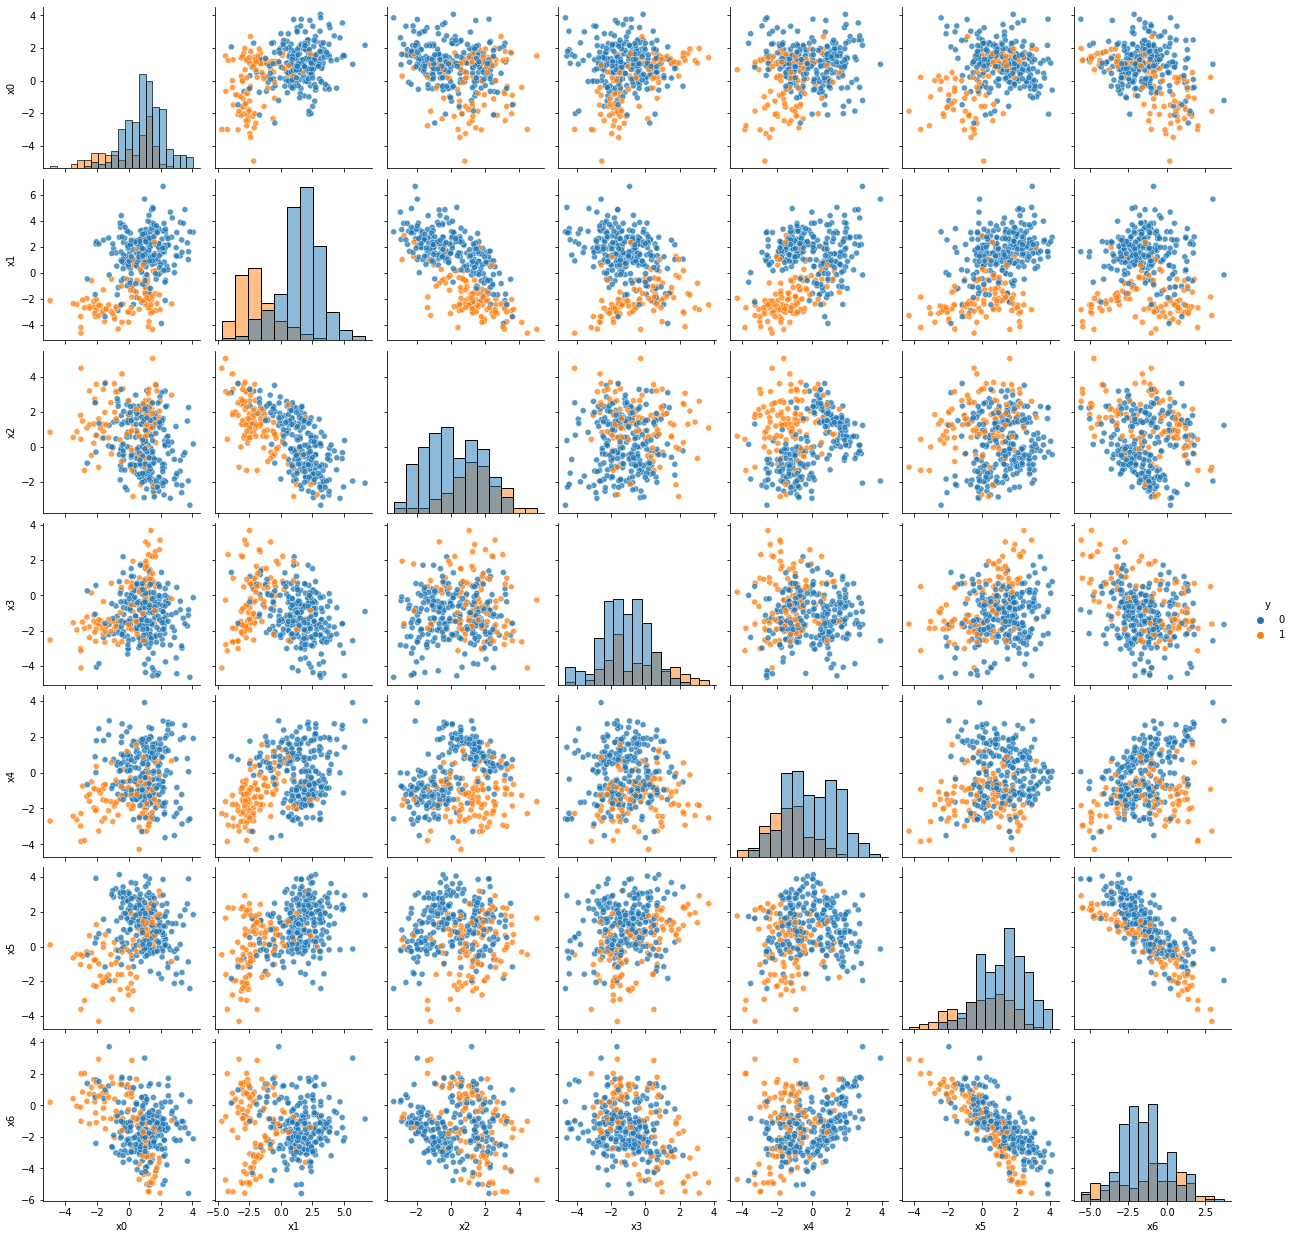

In [21]:
data = make_classification(n_samples      = 350, 
                            n_features    = 7, 
                            n_informative = 5, 
                            n_classes     = 2,
                            flip_y        = 0.1,
                            class_sep     = 1.23,
                            weights       = (.7, ))

df      = pd.DataFrame( data[0], columns = [ 'x{}'.format(str(i)) for i in range(len(data[0][1])) ] )
df['y'] = data[1]

sns.pairplot(df, plot_kws={'alpha':0.75}, hue='y', diag_kind="hist");

- - -

# brier loss

In [139]:
metadados = {
    'logreg':LogisticRegression(),
    'lgbm':lgb.LGBMClassifier(),
#     'rf': RandomForestClassifier(),
    'nb':GaussianNB()
}

In [148]:
curvas = dict()

In [169]:
for m in sorted(metadados):
    curvas[m] = dict()
    for w in np.arange(0.1, 1, 0.15):
        data = make_classification(n_samples      = 75000, 
                                    n_features    = 32, 
                                    n_informative = 2, 
                                    n_classes     = 2,
                                    flip_y        = 0.1,
                                    class_sep     = 1.23,
                                    weights=(w,))

        X = pd.DataFrame( data[0], columns = [ 'x{}'.format(str(i)) for i in range(len(data[0][1])) ] )
        y = data[1]
        Xt = StandardScaler().fit_transform(X)

        X_train, X_holdout, y_train, y_holdout = train_test_split(Xt, y, test_size = 0.2, random_state = 37)

        clf = metadados[m].fit(X_train, y_train)

        y_pred_holdout      = clf.predict(X_holdout)
        y_pred_holdout_prob = clf.predict_proba(X_holdout)
        fraction_of_positives, mean_predicted_value = calibration_curve(y_holdout, y_pred_holdout_prob[:,1], n_bins=30)

        score = brier_score_loss(y_holdout, y_pred_holdout_prob[:,1])

        curvas[m][str(round(w, 2))] = (mean_predicted_value, 
                                    fraction_of_positives, 
                                    score,
                                    pd.Series(y).value_counts(normalize=True).sort_index()[0], 
                                    pd.Series(y).value_counts(normalize=True).sort_index()[1],
                                    y_pred_holdout_prob[:,1])

## variando balanceamento

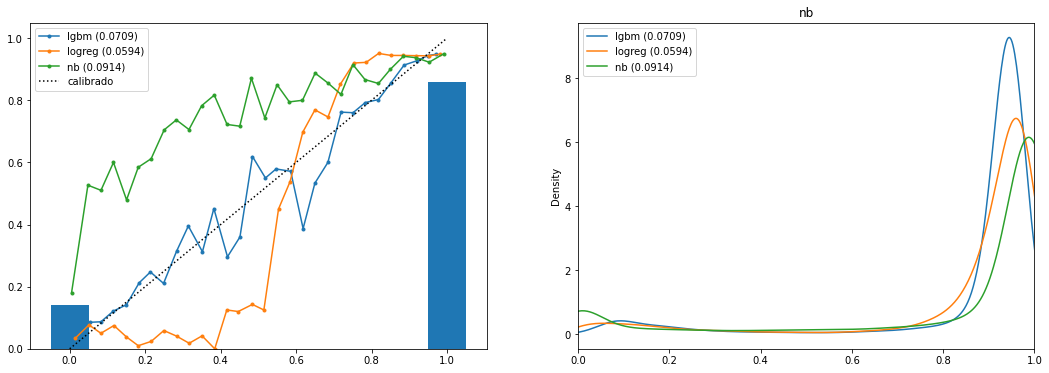

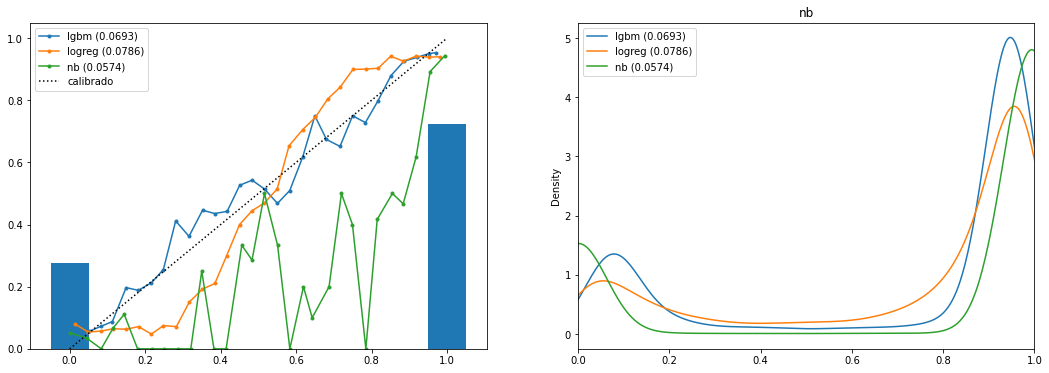

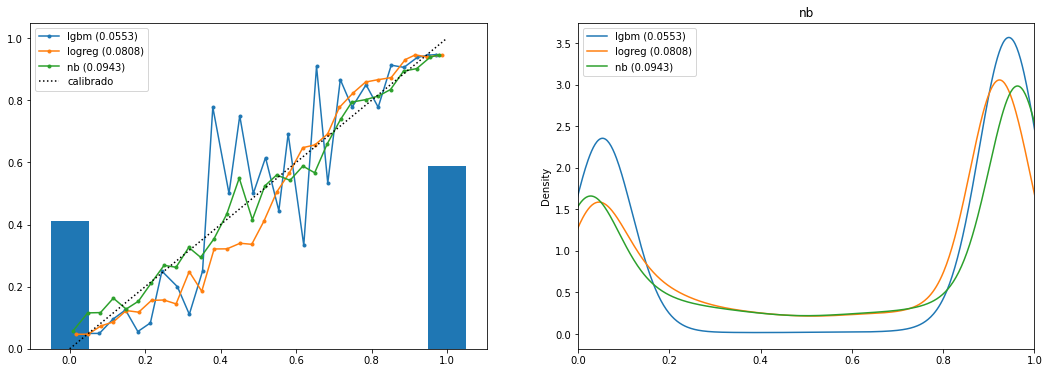

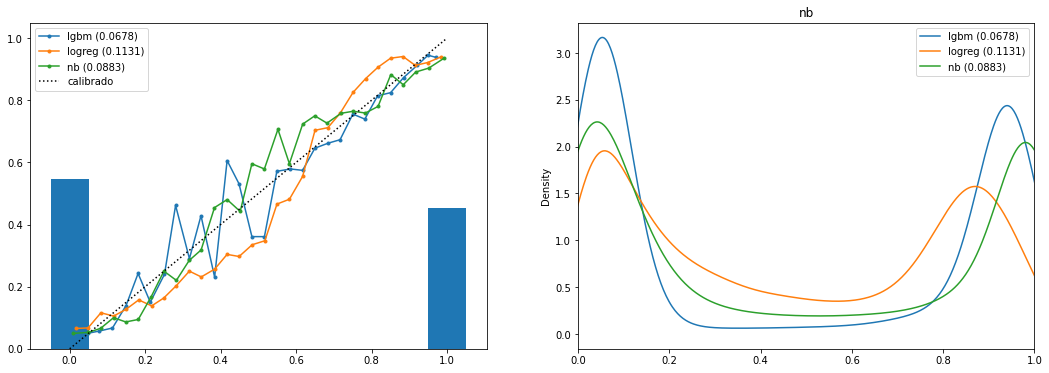

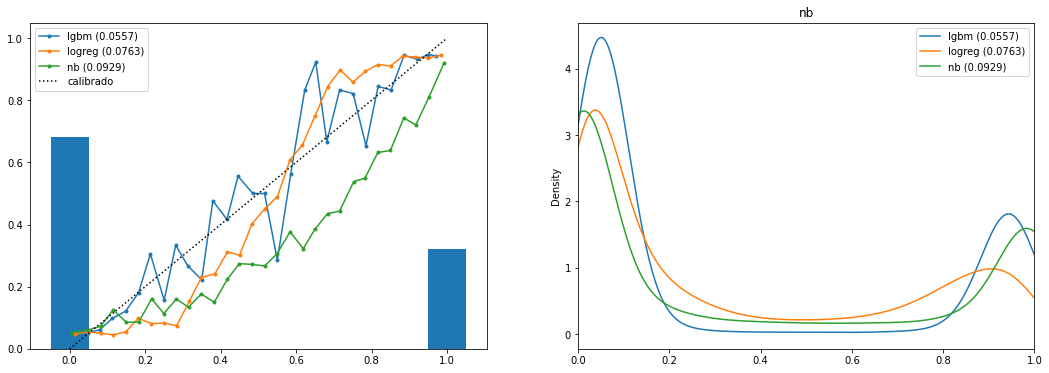

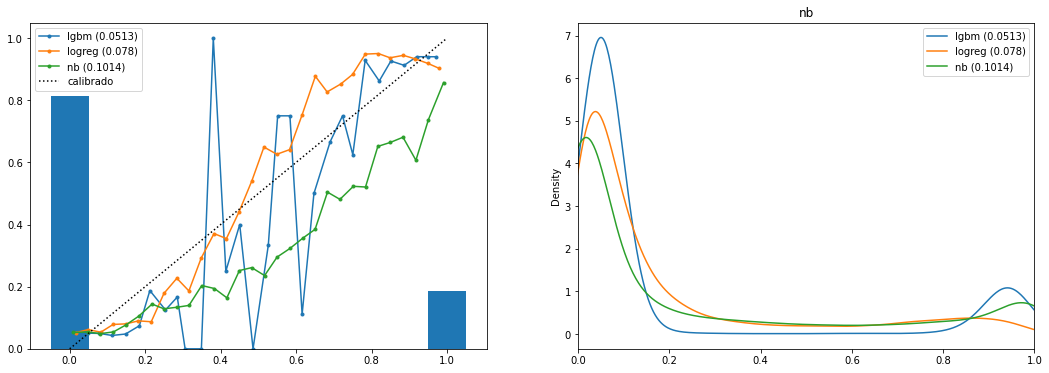

In [189]:
for w in sorted(curvas['lgbm']):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    
    for m in sorted(metadados):
        ax1.plot(curvas[m][w][0], curvas[m][w][1], ".-", label=rf"{m} ({round(curvas[m][w][2], 4)})")
        pd.Series(curvas[m][w][5]).plot(kind="kde", label=rf"{m} ({round(curvas[m][w][2], 4)})", ax=ax2)

    ax1.plot([0, 1], [0, 1], "k:", label="calibrado")

    ax1.bar([0, 1], [curvas[m][w][3], curvas[m][w][4]], width=0.1)

    ax1.legend()
    ax2.legend(); ax2.set_xlim([0,1])
    plt.title(rf"{m}")
    plt.show()

## variando modelo

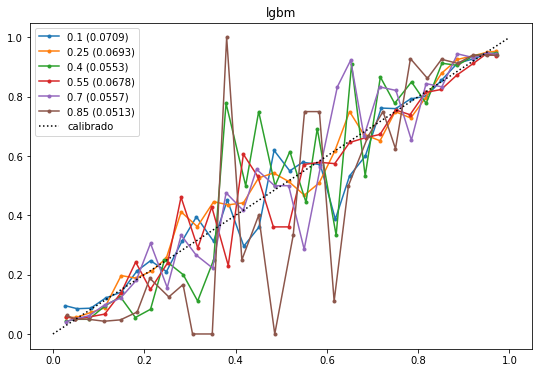

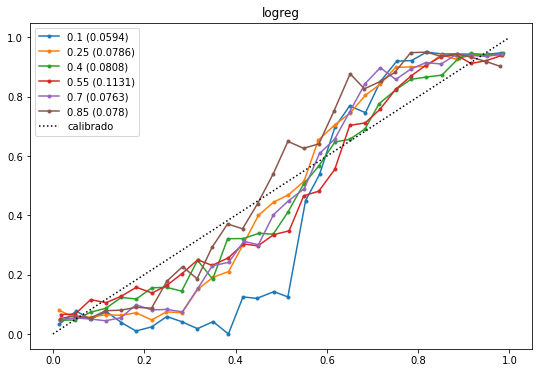

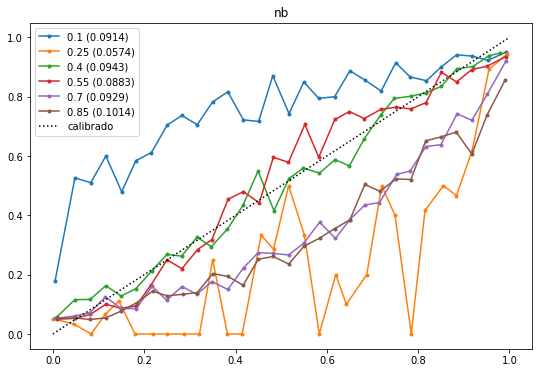

In [190]:
for m in sorted(metadados):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
    for w in sorted(curvas[m]):
        ax1.plot(curvas[m][w][0], curvas[m][w][1], ".-", label=rf"{w} ({round(curvas[m][w][2], 4)})")

    ax1.plot([0, 1], [0, 1], "k:", label="calibrado")

    plt.legend()
    plt.title(rf"{m}")
    plt.show()

# `dist(y_true_mean, bissetriz)`

In [191]:
metadados = {
    'logreg':LogisticRegression(),
    'lgbm':lgb.LGBMClassifier(),
#     'rf': RandomForestClassifier(),
    'nb':GaussianNB()
}

In [192]:
curvas = dict()

In [195]:
for m in sorted(metadados):
    curvas[m] = dict()
    for w in np.arange(0.1, 1, 0.15):
        data = make_classification(n_samples      = 75000, 
                                    n_features    = 32, 
                                    n_informative = 2, 
                                    n_classes     = 2,
                                    flip_y        = 0.1,
                                    class_sep     = 1.23,
                                    weights=(w,))

        X = pd.DataFrame( data[0], columns = [ 'x{}'.format(str(i)) for i in range(len(data[0][1])) ] )
        y = data[1]
        Xt = StandardScaler().fit_transform(X)

        X_train, X_holdout, y_train, y_holdout = train_test_split(Xt, y, test_size = 0.2, random_state = 37)

        clf = metadados[m].fit(X_train, y_train)

        y_pred_holdout      = clf.predict(X_holdout)
        y_pred_holdout_prob = clf.predict_proba(X_holdout)
        fraction_of_positives, mean_predicted_value = calibration_curve(y_holdout, y_pred_holdout_prob[:,1], n_bins=30)

        score = np.sum( [abs(v-fraction_of_positives[i]) for i,v in enumerate(mean_predicted_value)] )

        curvas[m][str(round(w, 2))] = (mean_predicted_value, 
                                    fraction_of_positives, 
                                    score,
                                    pd.Series(y).value_counts(normalize=True).sort_index()[0], 
                                    pd.Series(y).value_counts(normalize=True).sort_index()[1],
                                    y_pred_holdout_prob[:,1])

## variando balanceamento

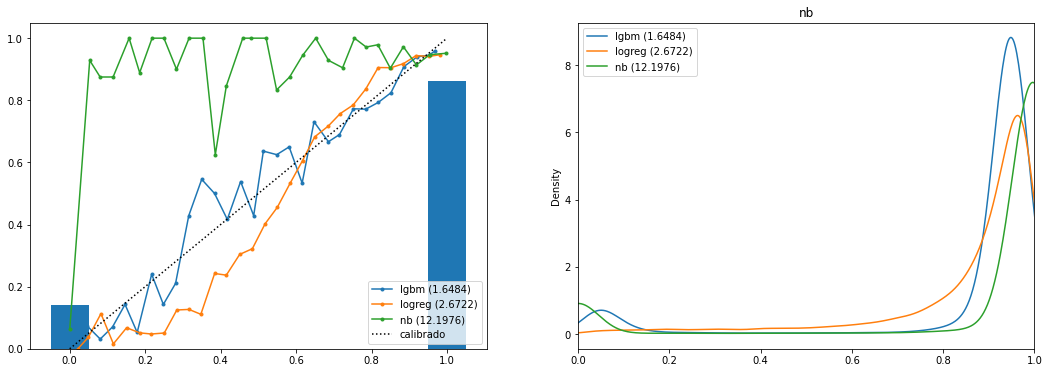

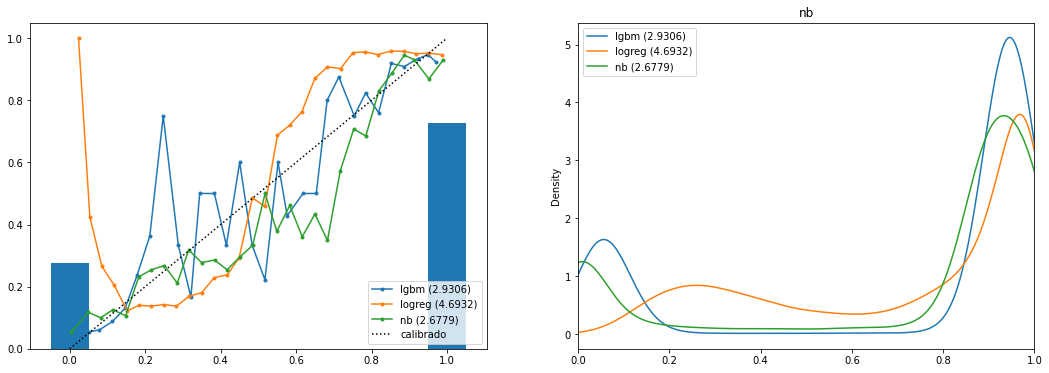

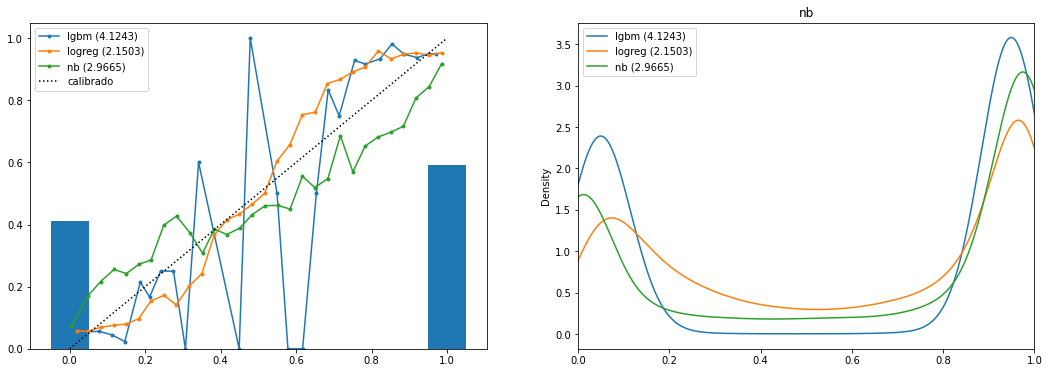

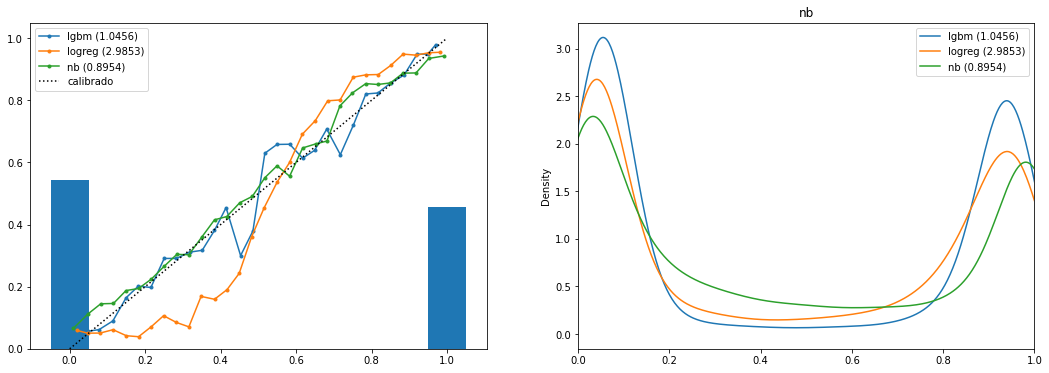

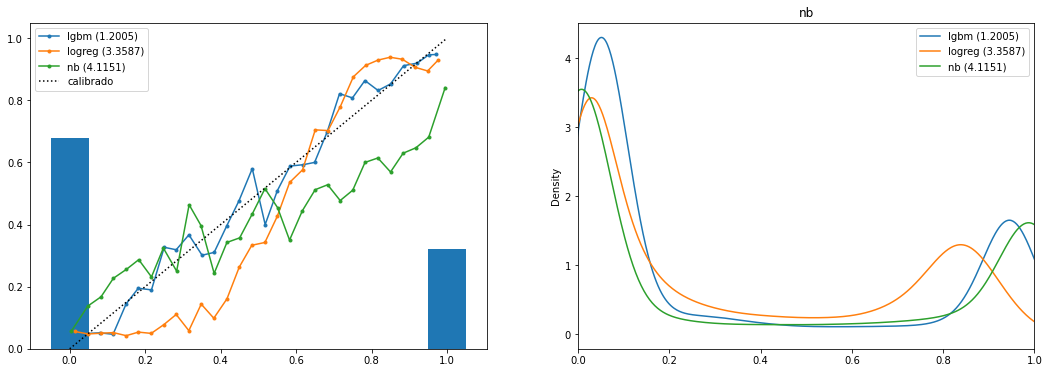

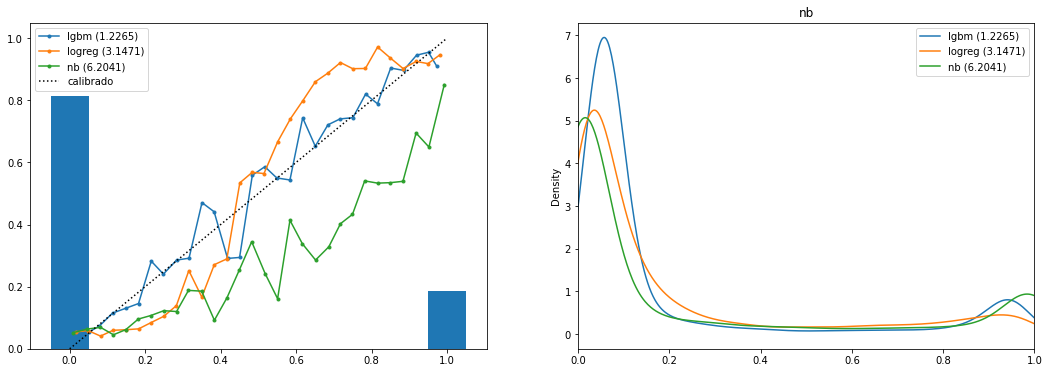

In [196]:
for w in sorted(curvas['lgbm']):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    
    for m in sorted(metadados):
        ax1.plot(curvas[m][w][0], curvas[m][w][1], ".-", label=rf"{m} ({round(curvas[m][w][2], 4)})")
        pd.Series(curvas[m][w][5]).plot(kind="kde", label=rf"{m} ({round(curvas[m][w][2], 4)})", ax=ax2)

    ax1.plot([0, 1], [0, 1], "k:", label="calibrado")

    ax1.bar([0, 1], [curvas[m][w][3], curvas[m][w][4]], width=0.1)

    ax1.legend()
    ax2.legend(); ax2.set_xlim([0,1])
    plt.title(rf"{m}")
    plt.show()

## variando modelo

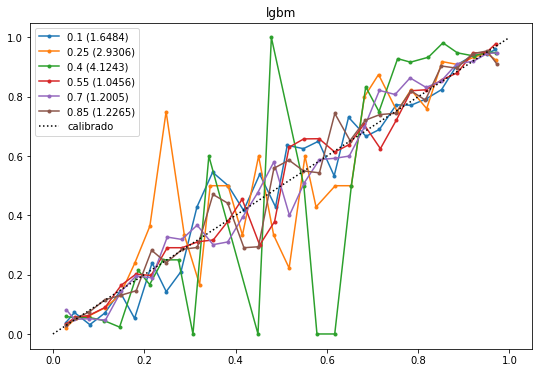

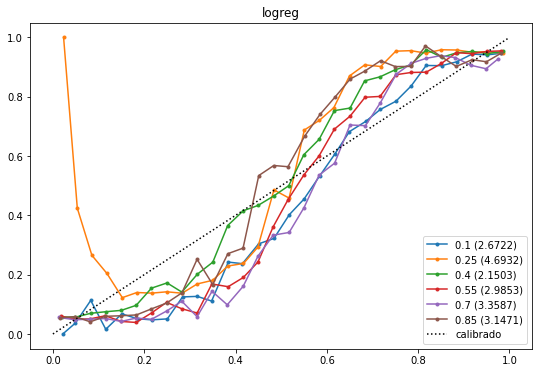

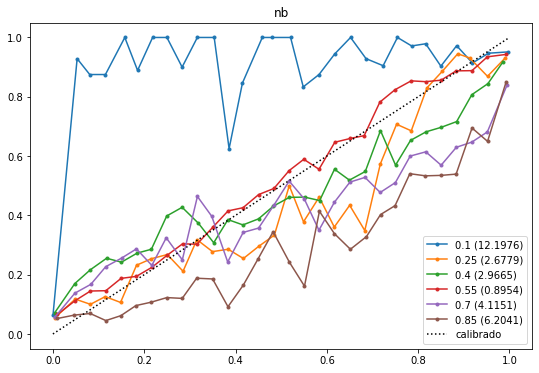

In [197]:
for m in sorted(metadados):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
    for w in sorted(curvas[m]):
        ax1.plot(curvas[m][w][0], curvas[m][w][1], ".-", label=rf"{w} ({round(curvas[m][w][2], 4)})")

    ax1.plot([0, 1], [0, 1], "k:", label="calibrado")

    plt.legend()
    plt.title(rf"{m}")
    plt.show()

# facilitando o problema

In [198]:
metadados = {
    'logreg':LogisticRegression(),
    'lgbm':lgb.LGBMClassifier(),
#     'rf': RandomForestClassifier(),
    'nb':GaussianNB()
}

In [199]:
curvas = dict()

In [200]:
for m in sorted(metadados):
    curvas[m] = dict()
    for w in np.arange(0.1, 1, 0.15):
        data = make_classification(n_samples      = 75000, 
                                    n_features    = 32, 
                                    n_informative = 16, 
                                    n_classes     = 2,
                                    flip_y        = 0.1,
                                    class_sep     = 1.23,
                                    weights=(w,))

        X = pd.DataFrame( data[0], columns = [ 'x{}'.format(str(i)) for i in range(len(data[0][1])) ] )
        y = data[1]
        Xt = StandardScaler().fit_transform(X)

        X_train, X_holdout, y_train, y_holdout = train_test_split(Xt, y, test_size = 0.2, random_state = 37)

        clf = metadados[m].fit(X_train, y_train)

        y_pred_holdout      = clf.predict(X_holdout)
        y_pred_holdout_prob = clf.predict_proba(X_holdout)
        fraction_of_positives, mean_predicted_value = calibration_curve(y_holdout, y_pred_holdout_prob[:,1], n_bins=30)

        score = brier_score_loss(y_holdout, y_pred_holdout_prob[:,1])

        curvas[m][str(round(w, 2))] = (mean_predicted_value, 
                                    fraction_of_positives, 
                                    score,
                                    pd.Series(y).value_counts(normalize=True).sort_index()[0], 
                                    pd.Series(y).value_counts(normalize=True).sort_index()[1],
                                    y_pred_holdout_prob[:,1])

## variando balanceamento

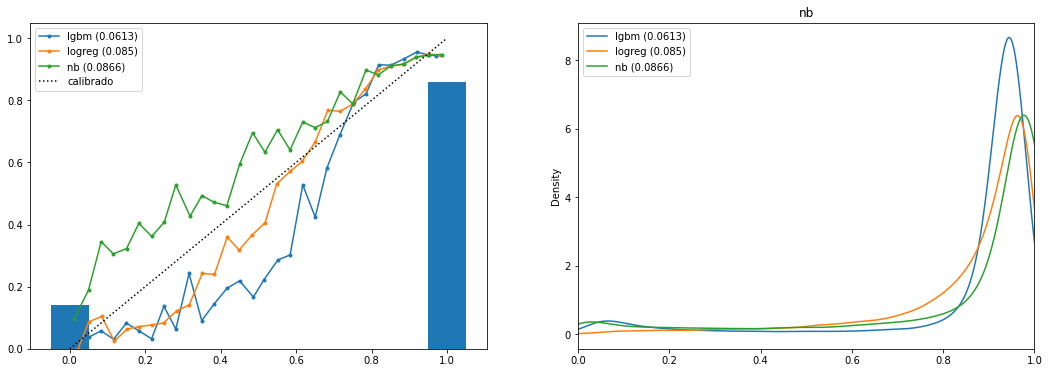

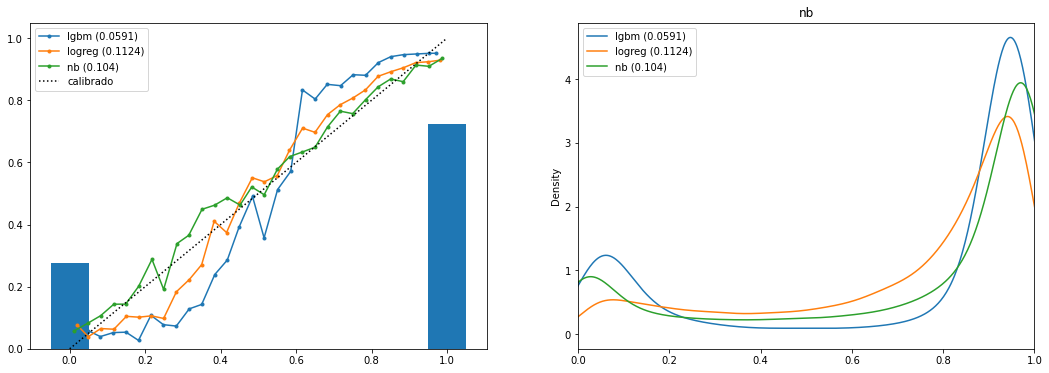

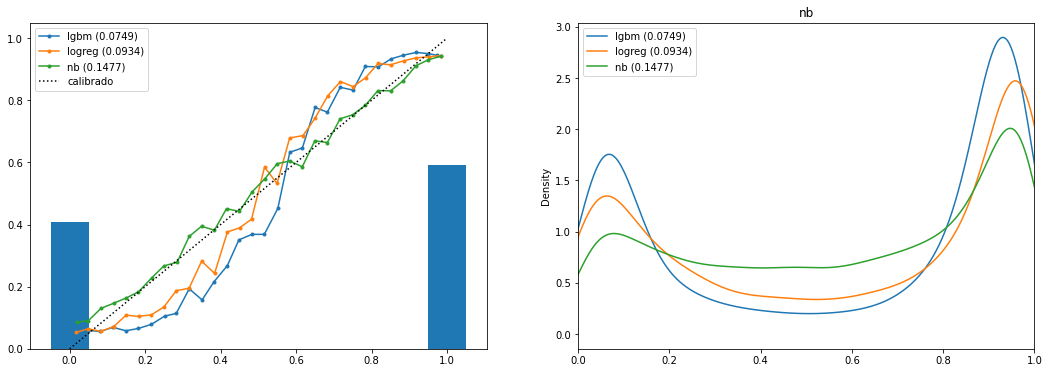

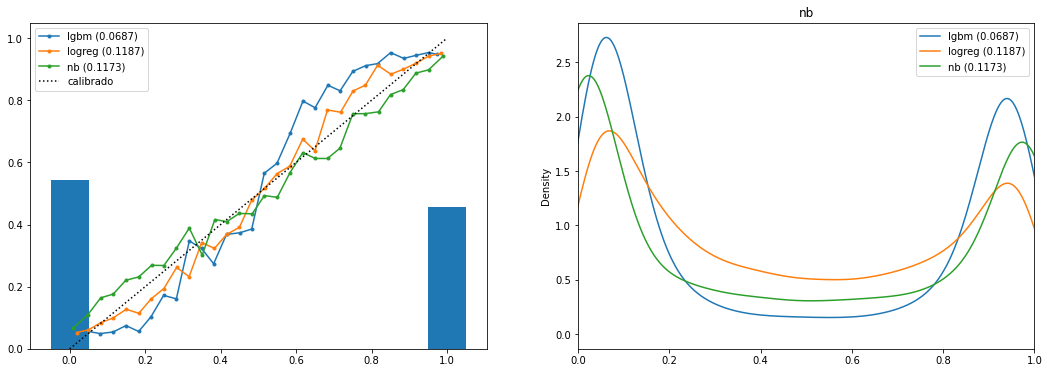

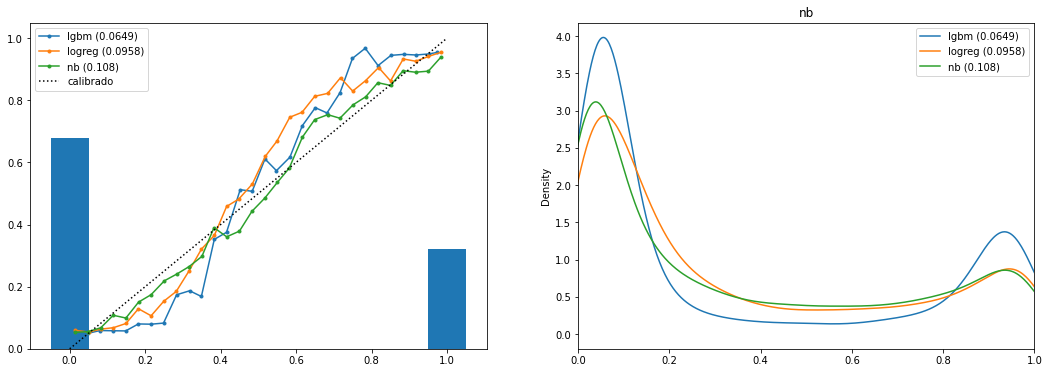

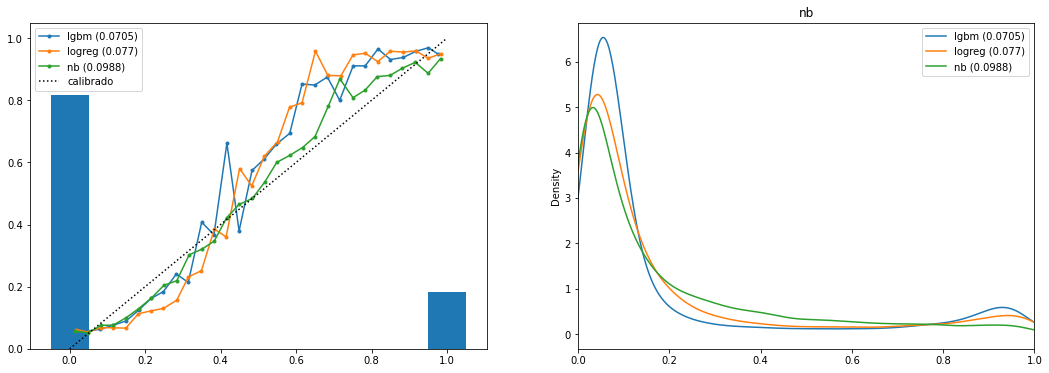

In [201]:
for w in sorted(curvas['lgbm']):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    
    for m in sorted(metadados):
        ax1.plot(curvas[m][w][0], curvas[m][w][1], ".-", label=rf"{m} ({round(curvas[m][w][2], 4)})")
        pd.Series(curvas[m][w][5]).plot(kind="kde", label=rf"{m} ({round(curvas[m][w][2], 4)})", ax=ax2)

    ax1.plot([0, 1], [0, 1], "k:", label="calibrado")

    ax1.bar([0, 1], [curvas[m][w][3], curvas[m][w][4]], width=0.1)

    ax1.legend()
    ax2.legend(); ax2.set_xlim([0,1])
    plt.title(rf"{m}")
    plt.show()

## variando modelo

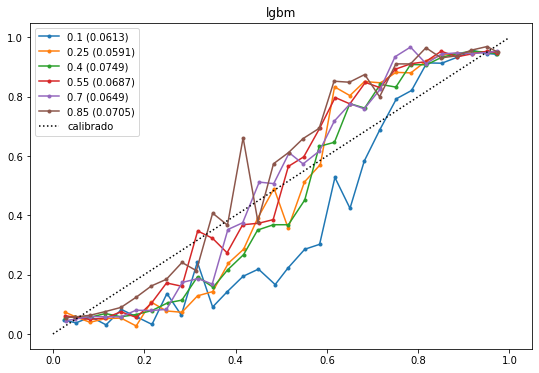

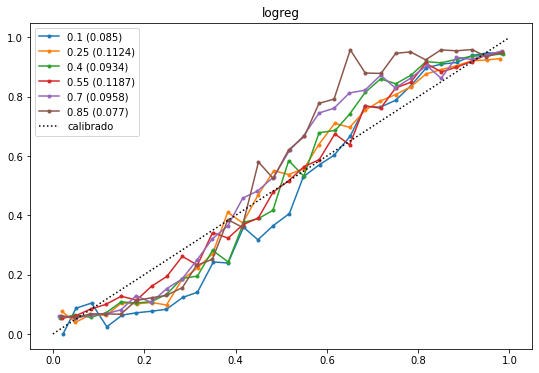

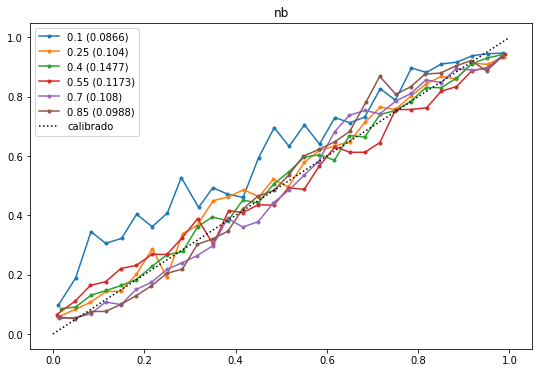

In [202]:
for m in sorted(metadados):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
    for w in sorted(curvas[m]):
        ax1.plot(curvas[m][w][0], curvas[m][w][1], ".-", label=rf"{w} ({round(curvas[m][w][2], 4)})")

    ax1.plot([0, 1], [0, 1], "k:", label="calibrado")

    plt.legend()
    plt.title(rf"{m}")
    plt.show()

.